In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
import os

from tqdm import tqdm

from sklearn import preprocessing, cluster, metrics, manifold, decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve

from matplotlib.image import imread

from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

## Sommaire

### <a href="#1"> Import du dataset
### <a href="#2"> Création des labels
### <a href="#3"> Encodage des labels
### <a href="#4"> Exemples d'affichage par label
### <a href="#5"> Etude de faisabilité
  -  <a href="#5a"> SIFT
  -  <a href="#5b"> CNN Transfer learning

## <a name="1"> Import du dataset

In [2]:
path = "./Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

df = pd.read_csv("./flipkart_com-ecommerce_sample_1050.csv")
data = df[['image','product_category_tree']]

1050


## <a name="2"> Création des labels

In [3]:
def recup_cat(liste_cat):
    """
    Renvoie la liste des catégories de liste_cat sans crochets ni apostrohes.
    Ainsi que la liste des différentes catégories.
    """
    liste = []
    l_cat = []
    for category in liste_cat:
        category = category.split(">>")[0]
        category = category.replace('"','').replace("'","").replace('[','')
        category = category[:-1]
        liste.append(category)
        if category not in(l_cat):
            l_cat.append(category)
    return liste, l_cat

In [4]:
categories, l_cat = recup_cat(data['product_category_tree'])
categories

['Home Furnishing',
 'Baby Care',
 'Baby Care',
 'Home Furnishing',
 'Home Furnishing',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Watches',
 'Home Furnishing',
 'Home Furnishing',
 'Home Furnishing',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Kitchen & Dining',
 'Home Furnishing',
 'Baby Care',
 'Home Furnishing',
 'Baby Care',
 'Beauty and Personal Care',
 'Kitchen & Dining',
 'Kitchen & Dining',
 'Kitchen & Dining',
 'Computers',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Kitchen & Dining',
 'Computers',
 'Kitchen & Dining',
 'Computers',
 'Computers',
 'Computers',
 'Beauty and Personal Care',
 'Beauty and Personal Care',
 'Beauty and Personal Care',
 'Beauty and Personal Care',
 'Bea

In [5]:
l_cat

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [6]:
data['label_name'] = categories
data = data[['image','label_name']]
data

C:\Users\matth\AppData\Local\Temp\ipykernel_4332\4074656248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_name'] = categories


,image,label_name
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care


## <a name="3"> Encodage des labels

In [7]:
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])
data

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [8]:
data.groupby("label").count()

,image,label_name
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


## <a name="4"> Exemples d'affichage par label

In [9]:
def list_fct(name) :
    """Créé une liste de toutes les photos qui ont le label name"""
    list_image_name = data.loc[data["label_name"]==name, 'image']
    return list_image_name

Home Furnishing


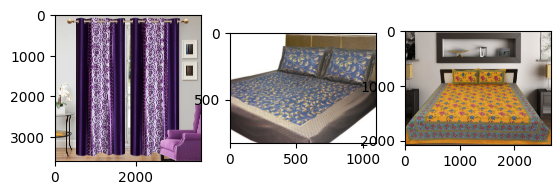

Baby Care


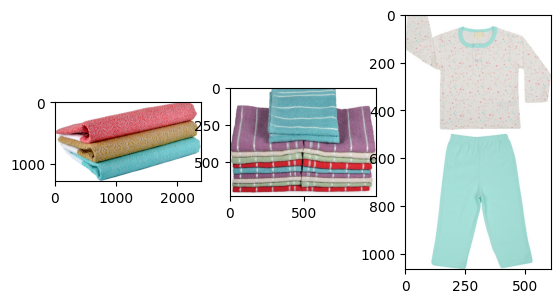

Watches


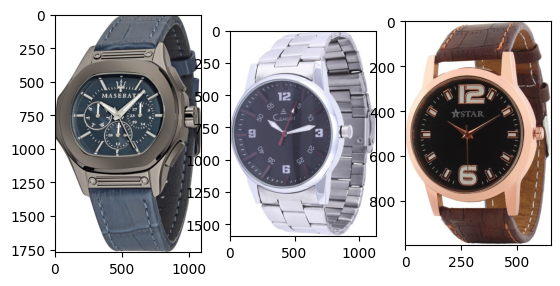

Home Decor & Festive Needs


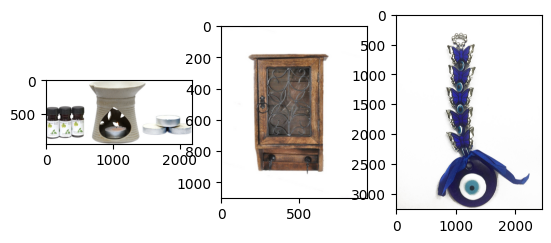

Kitchen & Dining


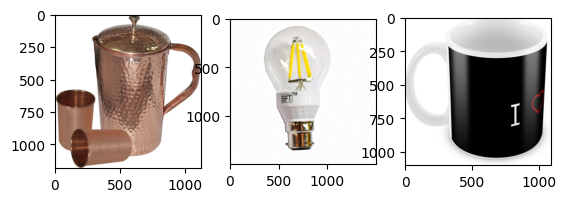

Beauty and Personal Care


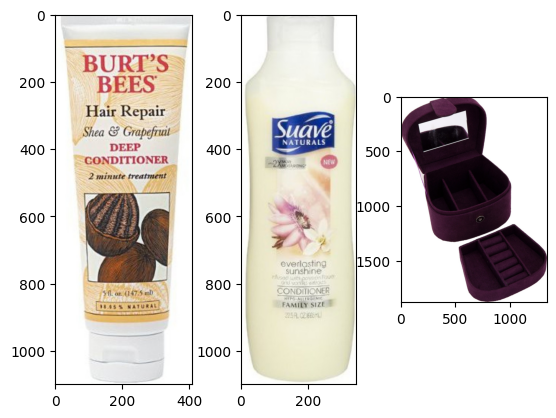

Computers


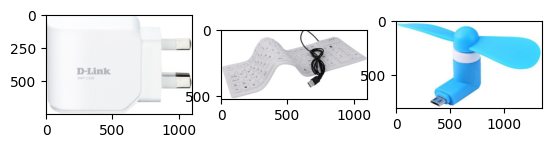

In [10]:
# Affiche un label et 3 photos de ce label

for nom in l_cat :
    print(nom)
    for i in range(3):
        plt.subplot(131+i)
        fichier = path + list_fct(nom).reset_index(drop = True)[i]
        image = imread(fichier)
        plt.imshow(image)
    plt.show()

# <a name="5"> Etude de faisabilité

## <a name="5a"> SIFT

### Détermination et affichage des descripteurs SIFT sur un exemple

* L'image contient 1305 descripteurs
* Chaque descripteur est un vecteur de longueur 128

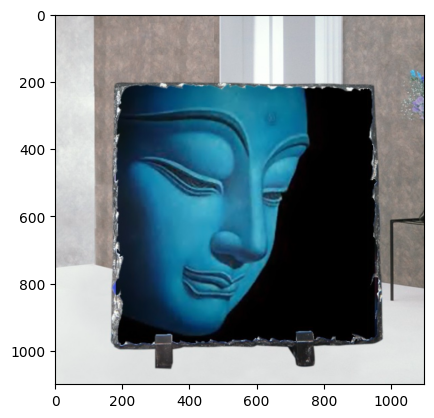

In [11]:
sift = cv2.SIFT_create()
image = cv2.imread(path+list_photos[15])
plt.imshow(image)

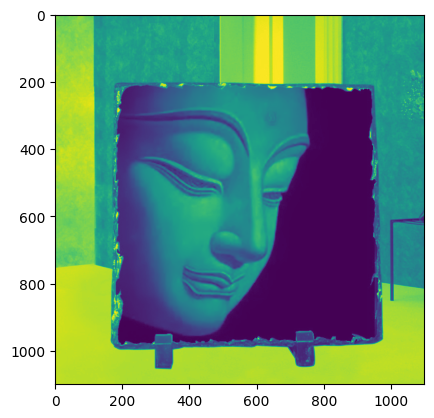

In [12]:
# conversion en gris

image = cv2.imread(path+list_photos[15],0) 
plt.imshow(image)

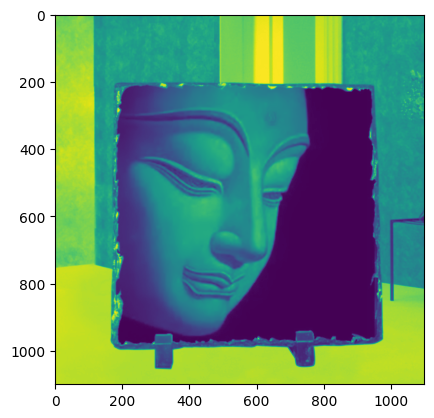

In [13]:
# applique un filtre gaussien pour réduire le bruit

image = cv2.GaussianBlur(image, (5, 5), 0) 
plt.imshow(image)

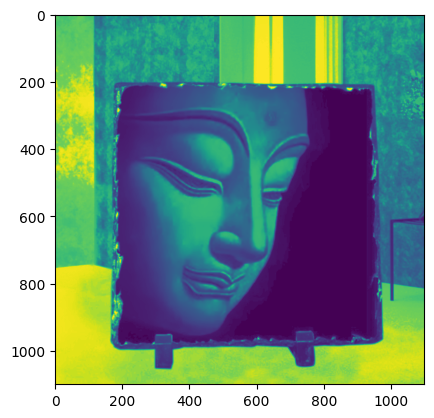

In [14]:
# égalisation
image = cv2.equalizeHist(image)
plt.imshow(image)

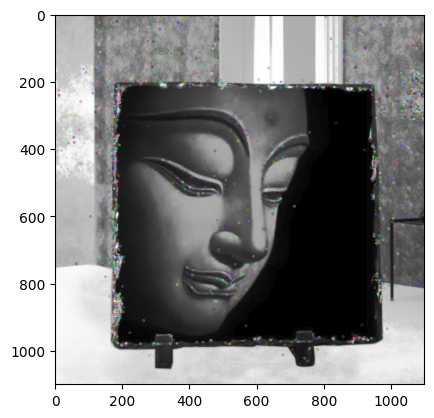

Descripteurs :  (1305, 128)

[[  0.   1.   6. ...  10.  23.  10.]
 [  9.   5.   0. ...  86.  72.  13.]
 [ 11.  11.   1. ...   0.   0.   1.]
 ...
 [ 40.  97.  77. ...   0.   0.   2.]
 [  0.   0.  54. ...  32. 120.   7.]
 [  5.  13. 125. ...  17.  35.  64.]]


In [15]:
# créé et affiche les descripteurs

kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

### Pré-traitement des images via SIFT

### Créations des descripteurs de chaque image
* Pour chaque image passage en gris, filtre gaussien et égalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [16]:
# identification des key points et des descripteurs associés
sift_keypoints = []
temps1 = time.time()
sift = cv2.SIFT_create(500)

for image_num in tqdm(range(len(list_photos))):
    image = cv2.imread(path+list_photos[image_num],0) #convertit en gris
    image = cv2.GaussianBlur(image, (5, 5), 0) # filtre gaussien
    res = cv2.equalizeHist(image) # équalise
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)
    
sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

100%|██████████| 1050/1050 [03:12<00:00,  5.46it/s]


Nombre de descripteurs :  (510032, 128)
temps de traitement SIFT descriptor :           192.40 secondes


### Création des clusters de descripteurs

In [17]:
# choix du nombre de clusters
k = 100
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

D:\anaconda3\envs\tf-2-9-1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Nombre de clusters estimés :  100
Création de 100 clusters de descripteurs ...


MiniBatchKMeans(init_size=300, n_clusters=100, random_state=0)

### Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image -> Histogramme d'une image -> Comptage pour une image du nombre de descripteurs par cluster

In [18]:
# Création des histogrammes

def build_histogram(kmeans, des, image_num):
    """créé un histogramme comptant le nombre de descripteurs par cluster"""
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [19]:
# Création de la matrice des histogrammes
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints) :
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)

Text(0, 0.5, 'Fréquence')

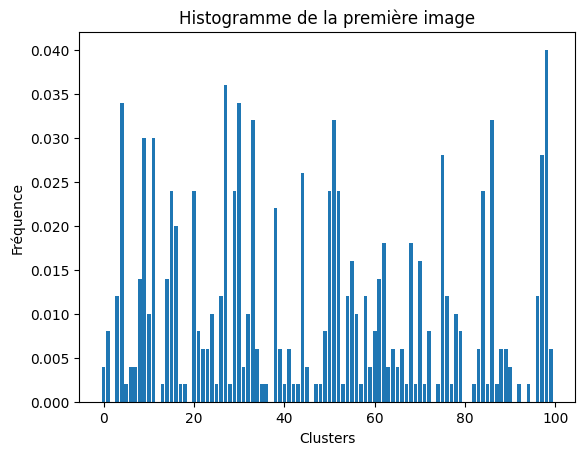

In [20]:
plt.bar(x = range(len(hist_vectors[0])),height = hist_vectors[0])
plt.title('Histogramme de la première image')
plt.xlabel('Clusters')
plt.ylabel('Fréquence')

### Réductions de dimensions

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [21]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 100)
Dimensions dataset après réduction PCA :  (1050, 79)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [22]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]
print(df_tsne.shape)

(1050, 3)


### Analyse visuelle : affichage T-SNE selon les catégories d'images

In [23]:
def visualisation_classes():
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2", hue="class", data=df_tsne,
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

    plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}, loc = (1.2,0.5)) 

    plt.show()

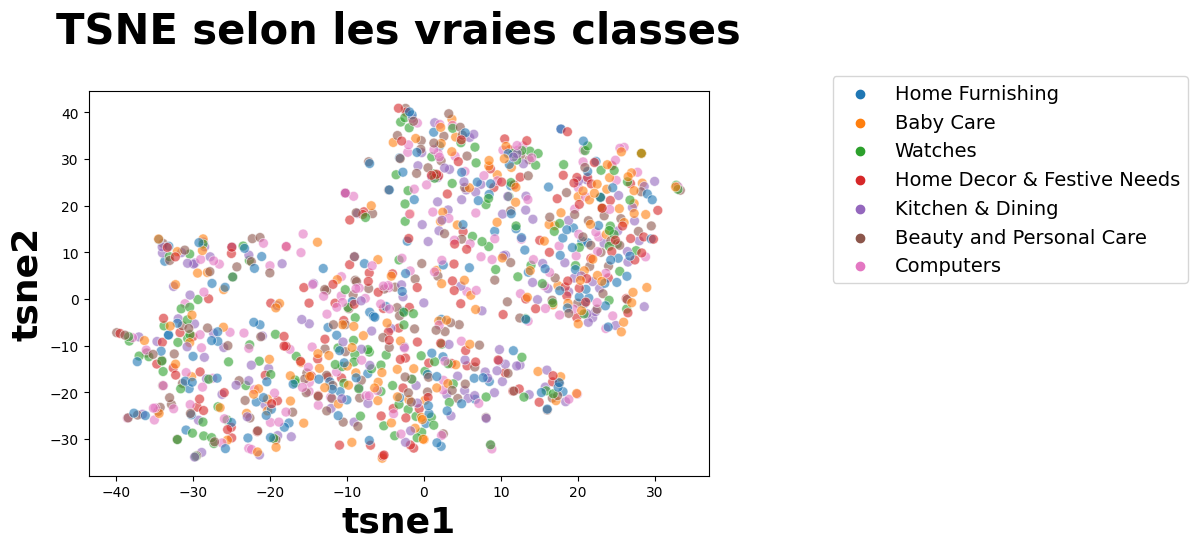

In [24]:
visualisation_classes()

Les catégories ne sont pas distinctes. L'affichage nous permet d'anticiper un mauvais clustering.

###  Création de clusters à partir du T-SNE

In [25]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


D:\anaconda3\envs\tf-2-9-1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

In [26]:
def visualisation_clusters():
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="cluster",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=df_tsne)

    plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 

    plt.show()

    labels = data["label"]
    print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

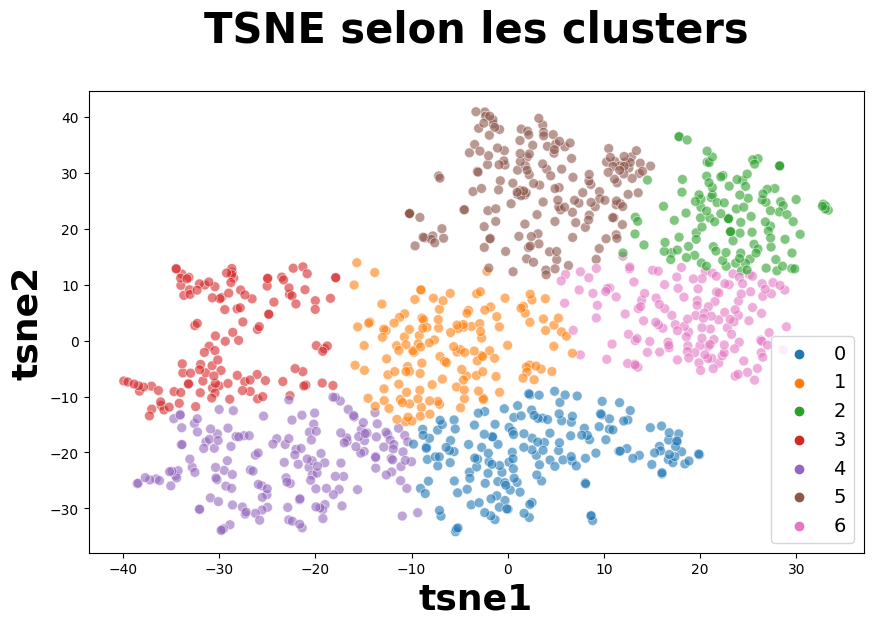

ARI :  -0.00037924570083963156


In [27]:
visualisation_clusters()

Le score ARI est très faible. Notre prédiction est confirmée.

### Analyse par classes
* La matrice de confusion doit être transformée pour avoir en colonne le même ordre des catégories supposées qu'en ligne

In [28]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    174
1    143
2    122
3    124
4    169
5    175
6    143
Name: class, dtype: int64

La catégorie numéro 3 n'a que 78 images au lieu des 150 !!!

In [29]:
labels = data["label"]
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[26 20 26 15 22 22 19]
 [21 26 14 19 28 26 16]
 [16 27 16 14 28 27 22]
 [26 23 19 13 24 25 20]
 [25 17 13 19 27 22 27]
 [31 14 14 24 18 27 22]
 [29 16 20 20 22 26 17]]


In [30]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [5 2 0 5 1 2 4]
[[26 22 42  0 19 41  0]
 [14 28 52  0 16 40  0]
 [16 28 54  0 22 30  0]
 [19 24 48  0 20 39  0]
 [13 27 39  0 27 44  0]
 [14 18 41  0 22 55  0]
 [20 22 42  0 17 49  0]]

              precision    recall  f1-score   support

           0       0.21      0.17      0.19       150
           1       0.17      0.19      0.18       150
           2       0.17      0.36      0.23       150
           3       0.00      0.00      0.00       150
           4       0.19      0.18      0.18       150
           5       0.18      0.37      0.25       150
           6       0.00      0.00      0.00       150

    accuracy                           0.18      1050
   macro avg       0.13      0.18      0.15      1050
weighted avg       0.13      0.18      0.15      1050



D:\anaconda3\envs\tf-2-9-1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\tf-2-9-1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\envs\tf-2-9-1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

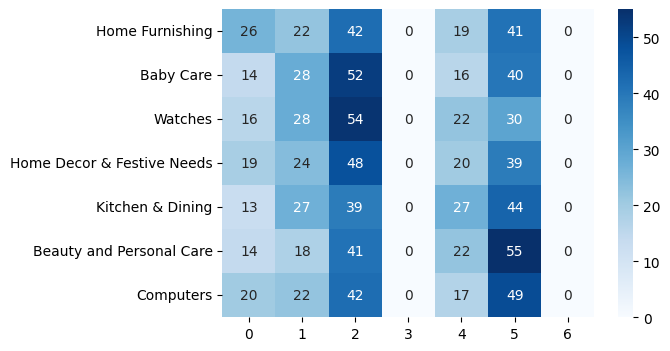

In [31]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion nous confirme le score ARI très faible. Les prédictions sont très mauvaises.

L'utilisation de SIFT nous donne de mauvais résultats. On ne peut pas l'utiliser pour notre classification d'images.

## <a name="5b"> CNN Transfer learning

### Création du modèle pré-entraîné

In [32]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Création des features des images

In [33]:
images_features = []

for image_file in tqdm(data["image"]) :
    image_file = "./Images/"+image_file
    image = load_img(image_file, target_size=(224, 224)) # charge l'image et la redimensionne
    image = img_to_array(image) # convertit l'image en tableau numpy
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image) # prétraite l'image
    images_features.append(model.predict(image, verbose=0)[0]) # predit la classe

images_features = np.asarray(images_features)
images_features.shape

 64%|██████▍   | 677/1050 [01:20<00:49,  7.48it/s]D:\anaconda3\envs\tf-2-9-1\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [02:44<00:00,  6.37it/s]


(1050, 4096)

In [34]:
image

array([[[[125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ],
         ...,
         [125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ]],

        [[125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ],
         ...,
         [125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ]],

        [[125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ],
         ...,
         [125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ],
         [125.061     , 104.221     , 114.32      ]],

### Réduction dimension et analyse

### Réduction de dimension PCA

In [35]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [36]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

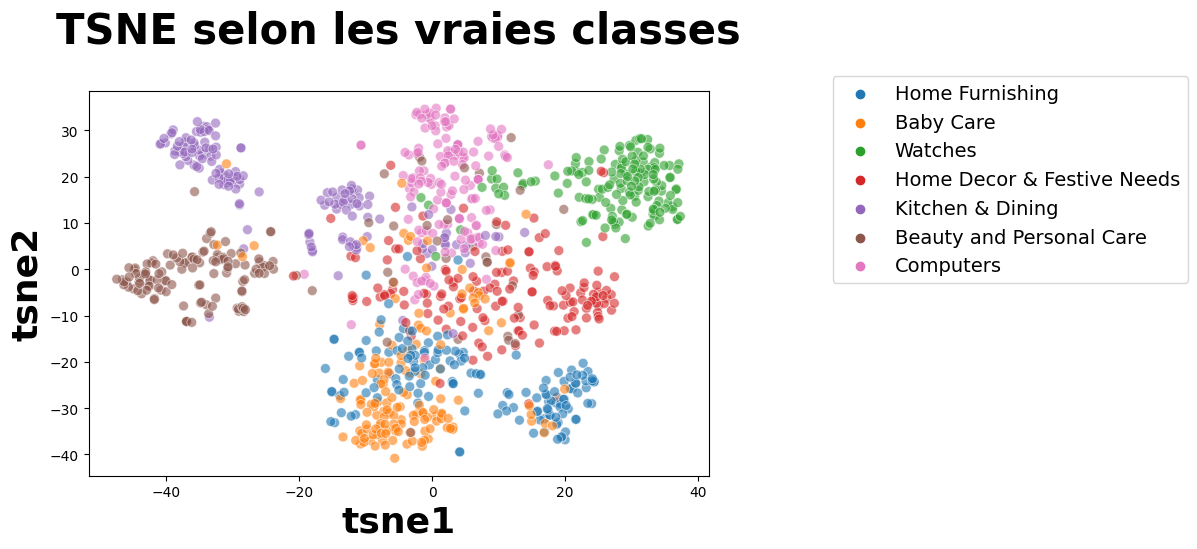

In [37]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

visualisation_classes()

Les clusters sont bien définis. Quelques catégories se mélangent : 'Home Furnishing', 'Baby Care' et 'Home Decor'.

On peut en conclure qu'il est possible de séparer automatiquement les images selon leur catégorie réelle.

In [38]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

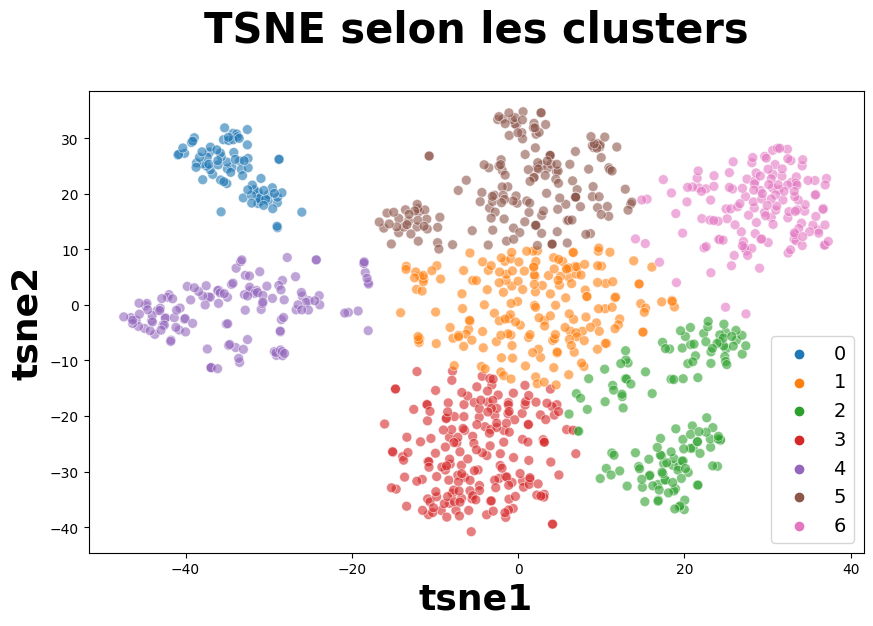

ARI :  0.44953276202571246


In [39]:
df_tsne["cluster"] = cls.labels_

visualisation_clusters()

Le score ARI est de 0.45. Cela confirme notre précédente conclusion.

### Analyse par classe

In [40]:
labels = data["label"]
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  1  26   9 109   3   1   1]
 [  1  12   5   5 117   9   1]
 [  0  35   0   2   1 111   1]
 [  0  78  56   2   1   5   8]
 [  0   6  68  76   0   0   0]
 [ 78  30   0   0  10  32   0]
 [  0   2   0   0   0  13 135]]


In [41]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [5 3 4 0 1 2 6]
[[109   3   1  26   9   1   1]
 [  5 117   9  12   5   1   1]
 [  2   1 111  35   0   0   1]
 [  2   1   5  78  56   0   8]
 [ 76   0   0   6  68   0   0]
 [  0  10  32  30   0  78   0]
 [  0   0  13   2   0   0 135]]

              precision    recall  f1-score   support

           0       0.56      0.73      0.63       150
           1       0.89      0.78      0.83       150
           2       0.65      0.74      0.69       150
           3       0.41      0.52      0.46       150
           4       0.49      0.45      0.47       150
           5       0.97      0.52      0.68       150
           6       0.92      0.90      0.91       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.67      1050
weighted avg       0.70      0.66      0.67      1050



<Axes: >

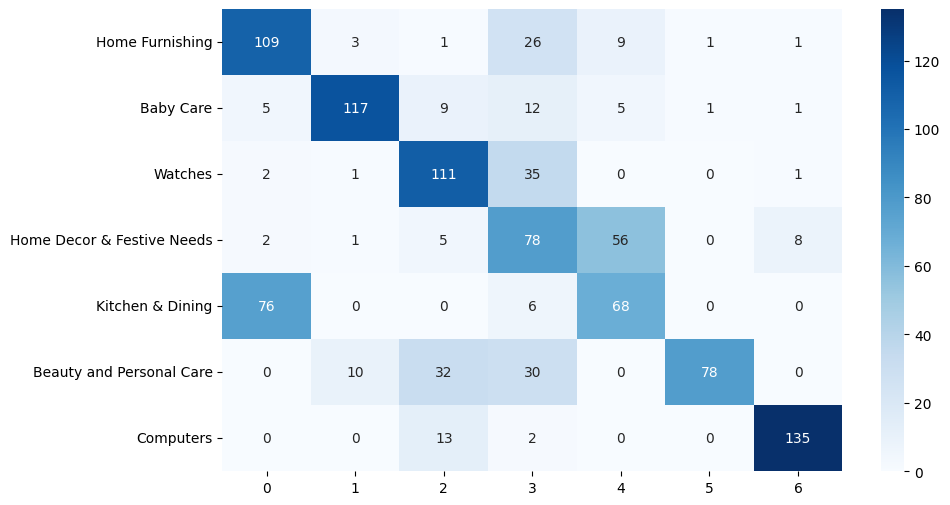

In [42]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (10,6))
sns.heatmap(df_cm, annot=True, cmap="Blues",fmt=".0f")

La matrice de confusion confirme le score ARI. Les classes 'Home decor', 'Kitchen & dining' et 'Beauty and personal care' sont les plus difficiles à prédire.